### 任务1:微调在ImageNet上预训练的卷积神经网络实现鸟类识别

下面是使用PyTorch实现在ImageNet上预训练的ResNet-18模型进行鸟类识别的代码示例：

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter

In [2]:
#加载数据集
from dataset_image import CUB
import transforms
from torch.utils.data import DataLoader
import time

time1 = time.time()
IMAGE_SIZE = 448
TRAIN_MEAN = [0.48560741861744905, 0.49941626449353244, 0.43237713785804116]
TRAIN_STD = [0.2321024260764962, 0.22770540015765814, 0.2665100547329813]
TEST_MEAN = [0.4862169586881995, 0.4998156522834164, 0.4311430419332438]
TEST_STD = [0.23264268069040475, 0.22781080253662814, 0.26667253517177186]

path = 'CUB_200_2011/CUB_200_2011'
train_transforms = transforms.Compose([
        transforms.ToCVImage(),
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
    ])

test_transforms = transforms.Compose([
    transforms.ToCVImage(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TEST_MEAN,TEST_STD)
    ])

train_dataset = CUB(
        path,
        train=True,
        transform=train_transforms,
        target_transform=None
    )
    # print(len(train_dataset))
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

test_dataset = CUB(
        path,
        train=False,
        transform=test_transforms,
        target_transform=None
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

time2 = time.time()

print(time2-time1)
train_len = train_dataset.__len__()
test_len = test_dataset.__len__()


0.02638530731201172


In [4]:
# 加载预训练的ResNet-18模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Linear(num_ftrs, 200)  # 将输出层大小设置为200
model = model.to(device)

512


### tensorboard可视化过程

In [ ]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 训练模型
num_epochs = 30
writer = SummaryWriter()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            dataloader=train_dataloader
            data_len=train_len
            model.train()
        else:
            dataloader=test_dataloader
            data_len=test_len
            model.eval()
        
        #dataloader=train_dataloader
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / data_len
        epoch_acc = running_corrects.double() / data_len

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            writer.add_scalar('Loss/train', epoch_loss, epoch)
            writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        else:
            writer.add_scalar('Loss/val', epoch_loss, epoch)
            writer.add_scalar('Accuracy/val', epoch_acc, epoch)

writer.close()

### matplotlib可视化过程

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# 假设 model, train_dataloader, test_dataloader 已经定义好了
# 定义损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 初始化变量用于存储损失和精度数据
train_losses, train_accuracies,val_losses, val_accuracies = [],[], [], []

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            dataloader = train_dataloader
            data_len = len(dataloader.dataset)
            model.train()
        else:
            dataloader = test_dataloader
            data_len = len(dataloader.dataset)
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).to(device)
                _, preds = torch.max(outputs, 1).to(device)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / data_len
        epoch_acc = (running_corrects.double() / data_len).cpu().item()

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

# 绘制损失和精度图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50
----------


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:7 and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

### 学习率分析

Training with learning rate: 0.001


/data/dell/anaconda3/envs/qyh/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/dell/anaconda3/envs/qyh/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
Epoch 1/26
----------
train Loss: 5.1820 Acc: 0.0177
val Loss: 4.7811 Acc: 0.0568
Epoch 2/26
----------
train Loss: 4.5152 Acc: 0.0781
val Loss: 4.0705 Acc: 0.1496
Epoch 3/26
----------
train Loss: 3.9033 Acc: 0.1735
val Loss: 3.4693 Acc: 0.2522
Epoch 4/26
----------
train Loss: 3.4775 Acc: 0.2594
val Loss: 3.0450 Acc: 0.3276
Epoch 5/26
----------
train Loss: 3.1254 Acc: 0.3227
val Loss: 2.7456 Acc: 0.3868
Epoch 6/26
----------
train Loss: 2.8464 Acc: 0.3767
val Loss: 2.4346 Acc: 0.4517
Epoch 7/26
----------
train Loss: 2.6152 Acc: 0.4321
val Loss: 2.2387 Acc: 0.4833
Epoch 8/26
----------
train Loss: 2.3992 Acc: 0.4718
val Loss: 2.0909 Acc: 0.5135
Epoch 9/26
----------
train Loss: 2.2416 Acc: 0.5090
val Loss: 1.9294 Acc: 0.5418
Epoch 10/26
----------
train Loss: 2.0802 Acc: 0.5470
val Loss: 1.8059 Acc: 0.5701
Epoch 11/26
----------
train Loss: 1.9319 Acc: 0.5816
val Loss: 1.6496 Acc: 0.6001
Epoch 12/26
----------
train Loss: 1.8348 Acc: 0.5963
val Loss: 1.5437 Acc: 0.6220
Epoch 13/

/data/dell/anaconda3/envs/qyh/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/dell/anaconda3/envs/qyh/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
Epoch 1/26
----------
train Loss: 4.8754 Acc: 0.0442
val Loss: 3.8665 Acc: 0.1293
Epoch 2/26
----------
train Loss: 3.5841 Acc: 0.1930
val Loss: 2.8390 Acc: 0.3045
Epoch 3/26
----------
train Loss: 2.8720 Acc: 0.3217
val Loss: 2.2656 Acc: 0.4089
Epoch 4/26
----------
train Loss: 2.4254 Acc: 0.4236
val Loss: 1.9058 Acc: 0.5016
Epoch 5/26
----------
train Loss: 2.0994 Acc: 0.4895
val Loss: 1.6225 Acc: 0.5670
Epoch 6/26
----------
train Loss: 1.8937 Acc: 0.5450
val Loss: 1.5537 Acc: 0.5925
Epoch 7/26
----------
train Loss: 1.6895 Acc: 0.5896
val Loss: 1.5331 Acc: 0.5982
Epoch 8/26
----------
train Loss: 1.5851 Acc: 0.6148
val Loss: 1.3794 Acc: 0.6412
Epoch 9/26
----------
train Loss: 1.4670 Acc: 0.6441
val Loss: 1.2797 Acc: 0.6600
Epoch 10/26
----------
train Loss: 1.3389 Acc: 0.6778
val Loss: 1.3294 Acc: 0.6455
Epoch 11/26
----------
train Loss: 1.2812 Acc: 0.6932
val Loss: 1.1974 Acc: 0.6726
Epoch 12/26
----------
train Loss: 1.2331 Acc: 0.6979
val Loss: 1.2078 Acc: 0.6833
Epoch 13/

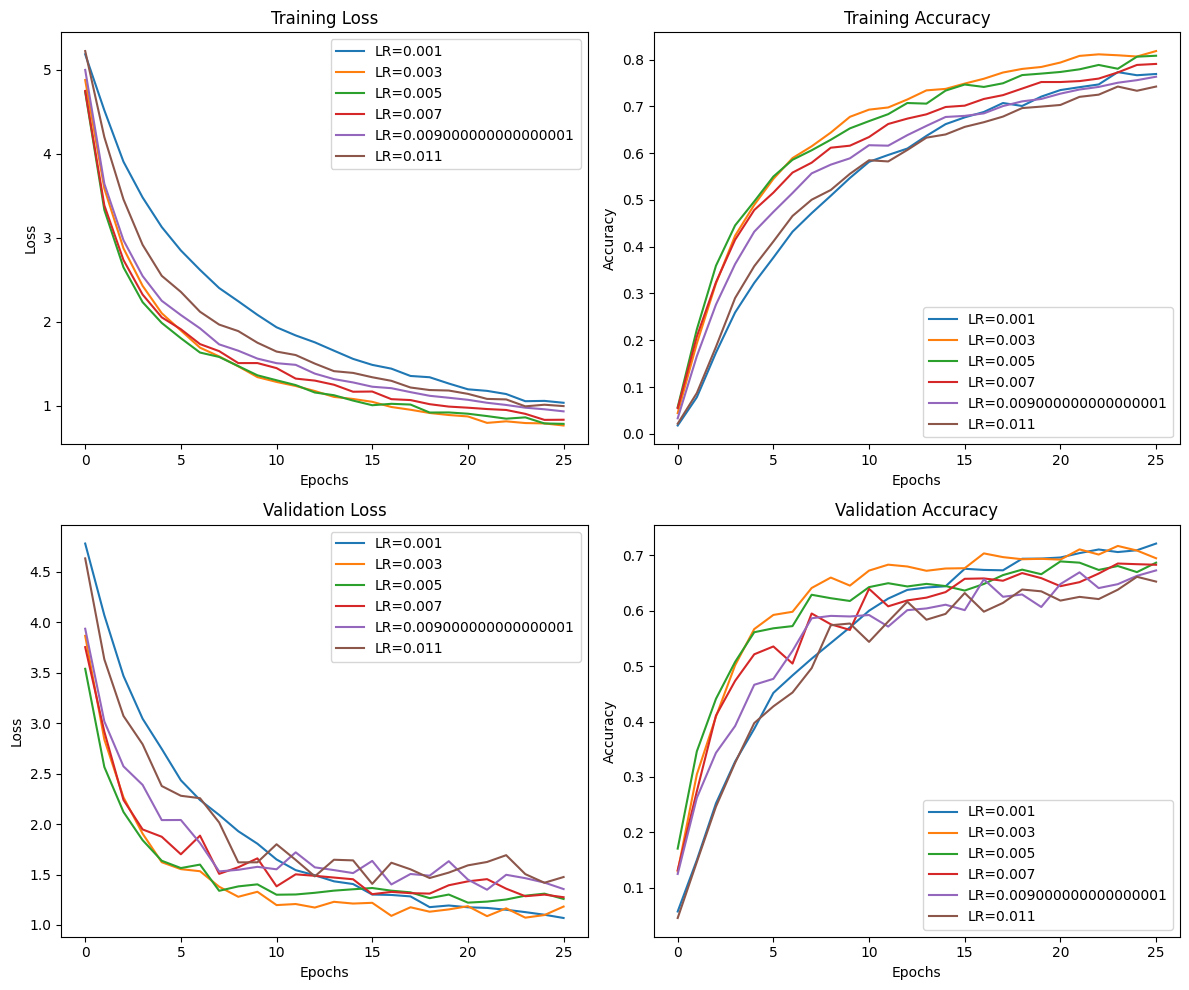

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np


# 存储每个学习率下的损失和准确率
lr_train_losses = []
lr_train_accuracies = []
lr_val_losses = []
lr_val_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 训练模型
num_epochs = 26
lrs = np.arange(0.001, 0.012, 0.002)
for lr in lrs:
    print(f'Training with learning rate: {lr}')
    # 加载预训练的ResNet-18模型
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    print(num_ftrs)
    model.fc = nn.Linear(num_ftrs, 200)  # 将输出层大小设置为200
    model = model.to(device)
    # 假设 model, train_dataloader, test_dataloader 已经定义好了
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    parameter=model.parameters()
    optimizer = optim.SGD(parameter, lr=lr, momentum=0.9)
    # 初始化变量用于存储损失和精度数据
    train_losses, train_accuracies,val_losses, val_accuracies = [],[], [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                data_len = len(dataloader.dataset)
                model.train()
            else:
                dataloader = test_dataloader
                data_len = len(dataloader.dataset)
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_len
            epoch_acc = (running_corrects.double() / data_len).cpu().item()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
    # 将每个学习率下的整体损失和准确率存储起来
    lr_train_losses.append(train_losses)
    lr_train_accuracies.append(train_accuracies)
    lr_val_losses.append(val_losses)
    lr_val_accuracies.append(val_accuracies)
# 绘制损失和精度图
# 绘制每个学习率下的损失和准确率图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, lr in enumerate(lrs):
    axes[0, 0].plot(lr_train_losses[i], label=f'LR={lr}')
    axes[0, 1].plot(lr_train_accuracies[i], label=f'LR={lr}')
    axes[1, 0].plot(lr_val_losses[i], label=f'LR={lr}')
    axes[1, 1].plot(lr_val_accuracies[i], label=f'LR={lr}')

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 批量大小


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np


# 存储每个学习率下的损失和准确率
lr_train_losses = []
lr_train_accuracies = []
lr_val_losses = []
lr_val_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 训练模型
num_epochs = 26
lrs = np.arange(10,60,10)
for lr in lrs:
    print(f'Training with batch size: {lr}')
    train_dataloader = DataLoader(
    train_dataset,
    batch_size=lr,
    num_workers=4,
    shuffle=True
    )
    test_dataloader = DataLoader(
    test_dataset,
    batch_size=lr,
    num_workers=4,
    shuffle=True
    )
    # 加载预训练的ResNet-18模型
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    print(num_ftrs)
    model.fc = nn.Linear(num_ftrs, 200)  # 将输出层大小设置为200
    model = model.to(device)
    # 假设 model, train_dataloader, test_dataloader 已经定义好了
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    parameter=model.parameters()
    optimizer = optim.SGD(parameter, lr=0.001, momentum=0.9)
    # 初始化变量用于存储损失和精度数据
    train_losses, train_accuracies,val_losses, val_accuracies = [],[], [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                data_len = len(dataloader.dataset)
                model.train()
            else:
                dataloader = test_dataloader
                data_len = len(dataloader.dataset)
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_len
            epoch_acc = (running_corrects.double() / data_len).cpu().item()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
    # 将每个学习率下的整体损失和准确率存储起来
    lr_train_losses.append(train_losses)
    lr_train_accuracies.append(train_accuracies)
    lr_val_losses.append(val_losses)
    lr_val_accuracies.append(val_accuracies)
# 绘制损失和精度图
# 绘制每个学习率下的损失和准确率图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, lr in enumerate(lrs):
    axes[0, 0].plot(lr_train_losses[i], label=f'Batch Size={lr}')
    axes[0, 1].plot(lr_train_accuracies[i], label=f'Batch Size={lr}')
    axes[1, 0].plot(lr_val_losses[i], label=f'Batch Size={lr}')
    axes[1, 1].plot(lr_val_accuracies[i], label=f'Batch Size={lr}')

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 优化动量


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np


# 存储每个学习率下的损失和准确率
lr_train_losses = []
lr_train_accuracies = []
lr_val_losses = []
lr_val_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 训练模型
num_epochs = 26
lrs = np.arange(0.1, 1.2, 0.2)
for lr in lrs:
    print(f'Training with learning rate: {lr}')
    # 加载预训练的ResNet-18模型
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    print(num_ftrs)
    model.fc = nn.Linear(num_ftrs, 200)  # 将输出层大小设置为200
    model = model.to(device)
    # 假设 model, train_dataloader, test_dataloader 已经定义好了
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    parameter=model.parameters()
    optimizer = optim.SGD(parameter, lr=0.001, momentum=lr)
    # 初始化变量用于存储损失和精度数据
    train_losses, train_accuracies,val_losses, val_accuracies = [],[], [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                data_len = len(dataloader.dataset)
                model.train()
            else:
                dataloader = test_dataloader
                data_len = len(dataloader.dataset)
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_len
            epoch_acc = (running_corrects.double() / data_len).cpu().item()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
    # 将每个学习率下的整体损失和准确率存储起来
    lr_train_losses.append(train_losses)
    lr_train_accuracies.append(train_accuracies)
    lr_val_losses.append(val_losses)
    lr_val_accuracies.append(val_accuracies)
# 绘制损失和精度图
# 绘制每个学习率下的损失和准确率图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, lr in enumerate(lrs):
    axes[0, 0].plot(lr_train_losses[i], label=f'Momentum={lr}')
    axes[0, 1].plot(lr_train_accuracies[i], label=f'Momentum={lr}')
    axes[1, 0].plot(lr_val_losses[i], label=f'Momentum={lr}')
    axes[1, 1].plot(lr_val_accuracies[i], label=f'Momentum={lr}')

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 图像尺寸

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np


# 存储每个学习率下的损失和准确率
lr_train_losses = []
lr_train_accuracies = []
lr_val_losses = []
lr_val_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 训练模型
num_epochs = 26
lrs = [112,224,448,560]
print(lrs)
for lr in lrs:
    print(f'Training with batch size: {lr}')
    print(type(lr))
    train_dataloader,test_dataloader=dataloader(lr,32)
    # 加载预训练的ResNet-18模型
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    print(num_ftrs)
    model.fc = nn.Linear(num_ftrs, 200)  # 将输出层大小设置为200
    model = model.to(device)
    # 假设 model, train_dataloader, test_dataloader 已经定义好了
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    parameter=model.parameters()
    optimizer = optim.SGD(parameter, lr=0.001, momentum=0.9)
    # 初始化变量用于存储损失和精度数据
    train_losses, train_accuracies,val_losses, val_accuracies = [],[], [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                data_len = len(dataloader.dataset)
                model.train()
            else:
                dataloader = test_dataloader
                data_len = len(dataloader.dataset)
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_len
            epoch_acc = (running_corrects.double() / data_len).cpu().item()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
    # 将每个学习率下的整体损失和准确率存储起来
    lr_train_losses.append(train_losses)
    lr_train_accuracies.append(train_accuracies)
    lr_val_losses.append(val_losses)
    lr_val_accuracies.append(val_accuracies)
# 绘制损失和精度图
# 绘制每个学习率下的损失和准确率图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, lr in enumerate(lrs):
    axes[0, 0].plot(lr_train_losses[i], label=f'Image Size={lr}')
    axes[0, 1].plot(lr_train_accuracies[i], label=f'Image Size={lr}')
    axes[1, 0].plot(lr_val_losses[i], label=f'Image Size={lr}')
    axes[1, 1].plot(lr_val_accuracies[i], label=f'Image Size={lr}')

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.show()